## Advanced Regression
### 자료 설명
- Toyota의 중고차 판매에 대한 자료
- 51개의 변수와 1436개의 관측값으로 구성 : 분석에는 10개의 변수만 사용
- 변수 설명
    - Price : 판매 가격
    - Age_08_04 : 자료 취득 시점까지 자동차 구동 시간
    - KM : 주행거리
    - Fuel_Type : 연료유형 (CNG, Diesel, Patrol)
    - HP : 마력
    - Met_Color : 금속 색이면 1, 아니면 0
    - Automatic : 자동변속이면 1, 아니면 0
    - cc : 실린더 부피
    - Quartely_Tax : 분기별 세금 (\$)
    - Weight : 무게(kg)
    
### 분석 목적 : 나머지 변수들로 Price를 예측하기
    
### 데이터 불러오기

## Formulation
1. Correlation 확인
2. Y Skew 확인
3. Outlier 확인
4. Missing Data 확인
5. Imputing Missing Data
### Pipeline 구성해나가기 : class에 fit-transform을 만들어가면 된다.
    6. Type 변경 : Numerical -> Categorical
    7. labeling
    7. Skew 여부 확인 : np.log1p

8. test-train split : test set도 같이 PCA를 해버리면 봐버리는 격 
    - pca.fit_transform(train) 하고 pca.transform(test)로 하면된다.
8. PCA를 위한 Scaling  : stadardscaler와 robustscaler
    - 이상치가 있다 싶으면 robustscaler로 
    - RobustScaler().fi_transform(X)를 하고 RobustScaler().transform(test)로
      fit은 train으로 test는 적용만 !
9. PCA 전에 feature importance으로 중요한 변수를 확인하고 결합하는 작업을 할 수있다.
    - 중요 변수를 뽑아내주는거는 Lasso, Ridge, Randomforest, gradientboosting을 활용할 수 있다.
    - 상위 몇개의 변수만을 뽑아서 작업을 해도 되지만,
      여기에서는 모든 변수를 사용했고 중요한 변수간의 결합하는 용도(?)로 사용했다.
8. PCA
    - 다중 공선성을 제거하기 위해 n개의 변수로 n개의 주성분을 뽑는 방식을 사용했다.
    - 차원을 축소하여 k(<n)개의 주성분을 뽑아서 계산을 수행할 수도 있지만
    - 여기에서는 차원 축소가 목적이 아니라 n개의 주성분을 모두 사용했다.
    - 마찬가지로 train으로 fit_transform을 하고 test는 transform만 한다.
    - Scaling이 중요하다!
9. Modeling
    - Lasso, ridge, Elasticnet, kernelridge, Randomforsetregressor, lightgbm
    - grid search를 활용하여 Parameter 를 찾자
10. Ensemble
    - Weight average : Grid search score 기반으로 가중치를 줘서 결과를 평균낸다.
    - Stacking
        - 아래처럼 바꿔주지 않으면 에러난다 value error: nan, infinity~~~
        - a = Imputer().fit_transform(train_X_pca)
        - b = Imputer().fit_transform(y_train.reshape(-1,1)).ravel()
        
## 일반모델로 Test RMSE 0.11, Weight average로 0.10, Stacking으로 0.099 달성!!


-------


In [186]:
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [305]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge

In [188]:
import pandas as pd
import numpy as np

toyota = pd.read_csv('ToyotaCorolla.csv', delimiter = ',')
# unknown 삭제, ID 삭제
toyota = toyota.iloc[:,2:-13]
toyota.head()


,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,Automatic,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,13500,23,10,2002,46986,Diesel,90,1,Blue,0,...,1,1,1,0,0,0,1,0,0,0
1,13750,23,10,2002,72937,Diesel,90,1,Silver,0,...,1,0,1,0,0,0,1,0,0,0
2,13950,24,9,2002,41711,Diesel,90,1,Blue,0,...,0,0,1,0,0,0,1,0,0,0
3,14950,26,7,2002,48000,Diesel,90,0,Black,0,...,0,0,1,0,0,0,1,0,0,0
4,13750,30,3,2002,38500,Diesel,90,0,Black,0,...,1,1,1,0,1,0,1,0,0,0


### 0. Correlation 확인 : heatmap
    - price와 age가 역의 상관관계가있다.
    - price와 mfg_year가 양의 상관관계
    - central_lock과 powered_window는 강한 상관관계가 있다.
    - Quarterly_tz와 weight가 강한 상관관계가 있다.
    - radio와 radio_casset이 당연하게 관계가 있다.

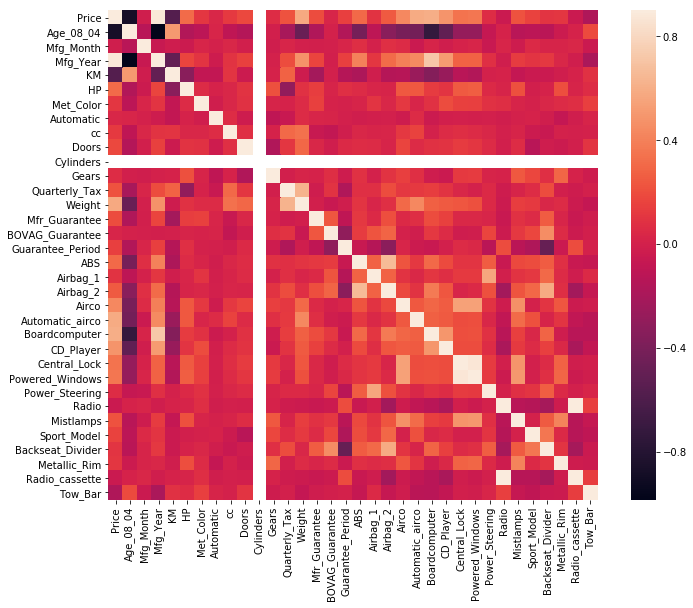

In [189]:
t_corr=toyota.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(t_corr, vmax=0.9, square=True)

### 1. Y Skew 여부 확인
    - Y가 Skew 되어 있는지를 보고 Skew 되어 있다면 np.log1p 값으로 대체하자

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


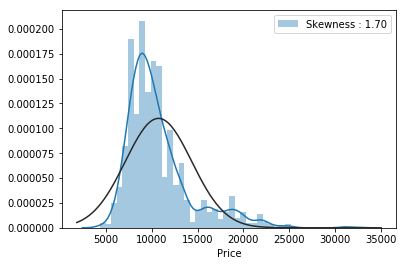

In [190]:
# price의 분포를 확인하자 
# 왼쪽으로 Skew 되어 있다. 이것에 log를 씌우자
g = sns.distplot(toyota['Price'], fit = norm,label="Skewness : %.2f"%(toyota["Price"].skew()))
g =g.legend(loc = "best")


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


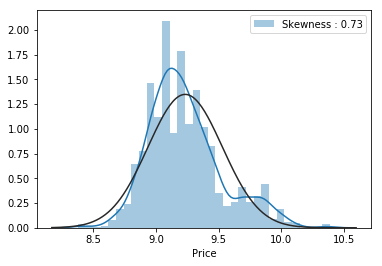

In [191]:
# skew 된 Y를 업데이트 하기
g1 = sns.distplot(np.log1p(toyota['Price']), 
                 fit = norm,
                 label="Skewness : %.2f"%(np.log1p(toyota["Price"]).skew()))
g1 =g1.legend(loc = "best")

toyota['Price'] = np.log1p(toyota['Price'])


### 2. Outlier 확인
    - float64 type의 variable과 Y간의 관계를 보고 이상치 있는지를 확인
    - 이상치로 볼만한 건이 없다.

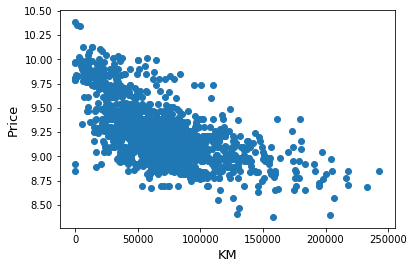

In [192]:
# km와 price의 관계를 보자
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(toyota['KM'], toyota['Price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('KM', fontsize=13)
plt.show()

# 가격이 높은 차가 있다. 이 차는 이상치로 볼것인가?
# 이정도면 이상치라고 보기는 좀 힘들것 같다. pass

### 3. Missing Data 
    - 이 데이터에는 missing data가 없다

In [193]:
toyota.isnull().sum()[toyota.isnull().sum()>0]

Series([], dtype: int64)

### 4. Imputing Missing Value
    - 이 데이터에는 missing data가 없으므로 pass

### 5. Pipe line 구성해나가기
    - fit은 return self를 해줘야한다!
    - categorical로 변경
    - skew 데이터 처리하기 (categorical value가 아닌 것으로)
    - feature 추가 : mfg_year + mfg_month

In [194]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [222]:
# int -> categorical로 변경 class

class changeType(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        num_cols = ['Mfg_Month','Mfg_Year','HP','Met_Color','Automatic','cc','Doors',
                   'Cylinders','Gears','Quarterly_Tax']
        num_cols.append(toyota.columns[17:])
        for col in num_cols:
            x[col] = x[col].astype(str)
        return x
# changeType().transform(toyota).dtypes

In [223]:
# skew 데이터 처리

class Skew(BaseEstimator, TransformerMixin):
    def __init__(self,skew=1):
        self.skew = skew
    def fit(self,x,y=None):
        return self
    def transform(self,X):
        cols = X.dtypes[toyota.dtypes == 'int64'].index
        for col in cols :
            if skew(X[col])>self.skew :
#                 print(col)
                X[col]=np.log1p(X[col])
        return X
# Skew(skew=1).transform(toyota)

In [231]:
# dummy 생성 

class Getdummy(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    def transform(self,X):
        return pd.get_dummies(X, drop_first = True)
# Getdummy().transform(toyota).head()

### Pipeline

In [232]:
pipe = Pipeline([
    ('changetype',changeType()),
    ('Skew',Skew(skew=1)),
    ('Getdummy',Getdummy()),
    ('Scaling',scaler())
])

In [233]:
toyota.head()

,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,Automatic,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,9.510519,23,10,2002,10.757626,Diesel,90,1,Blue,0,...,1,1,1,0,0,0,1,0,0,0
1,9.528867,23,10,2002,11.197365,Diesel,90,1,Silver,0,...,1,0,1,0,0,0,1,0,0,0
2,9.543306,24,9,2002,10.638544,Diesel,90,1,Blue,0,...,0,0,1,0,0,0,1,0,0,0
3,9.612533,26,7,2002,10.778977,Diesel,90,0,Black,0,...,0,0,1,0,0,0,1,0,0,0
4,9.528867,30,3,2002,10.558439,Diesel,90,0,Black,0,...,1,1,1,0,1,0,1,0,0,0


In [234]:
# Pipeline 실행
full_data =  pipe.fit_transform(toyota)

### 6. train-test set 분리하기
    - PCA 나 변수 선택과 같은 작업을 할 때는 반드시 나눠주고 해야한다.
    

In [240]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size = 0.2, random_state = 42)
X_train, y_train = train.drop("Price", axis = 1), train.Price
X_test, y_test = test.drop("Price", axis = 1), test.Price

### 7. Scaling 
    - 변수가 대부분 정리가 다 된상태에서 scaling을 실시한다
    - 이상치가 있을 수 있으니 robustscaler를 활용한다.

In [246]:
scaler = RobustScaler()
# X_train으로 fit한 후 transform 하고
# X_test를 fit 한 것에 넣어 transform만 수행한다.
X_scaled = scaler.fit_transform(X_train)
test_X_scaled = scaler.transform(X_test)

## 8. Feature selection
    - 변수를 뽑아낼 목적으로 사용할 수도 있지만 여기에서는 그냥 보기만 할 것
    - Lasso는 관련있는 변수만 골라서 보여준다.

(array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2]),
 <a list of 7 Text xticklabel objects>)

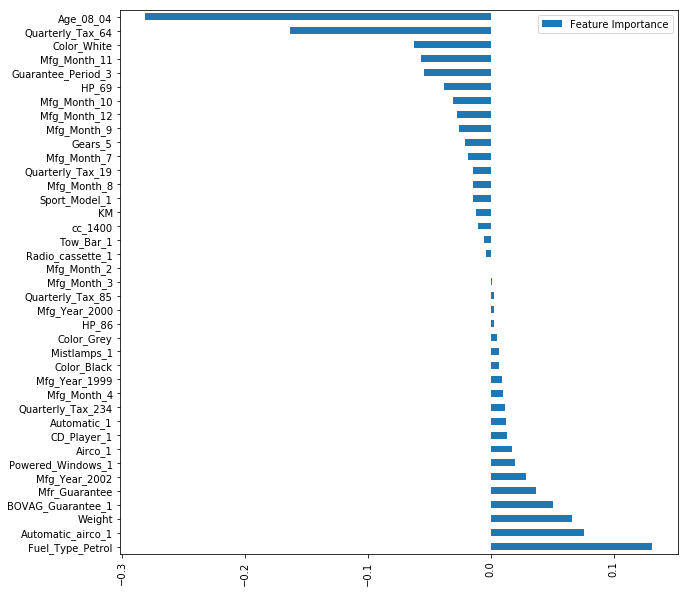

In [261]:
# Lasso를 활용한 feature importance
lasso = Lasso(alpha = 0.001)
lasso.fit(X_scaled,y_train)
# lasso는 관련있는 변수만 골라서 보여준다
df_lasso = pd.DataFrame({"Feature Importance":lasso.coef_},
                       index = full_data.iloc[:,1:].columns)
df_lasso.sort_values("Feature Importance",ascending=False)

#graph
p = df_lasso[df_lasso.iloc[:,0]!=0].sort_values("Feature Importance",ascending=False) \
    .plot(kind="barh",figsize = (10,10))
plt.xticks(rotation = 90)


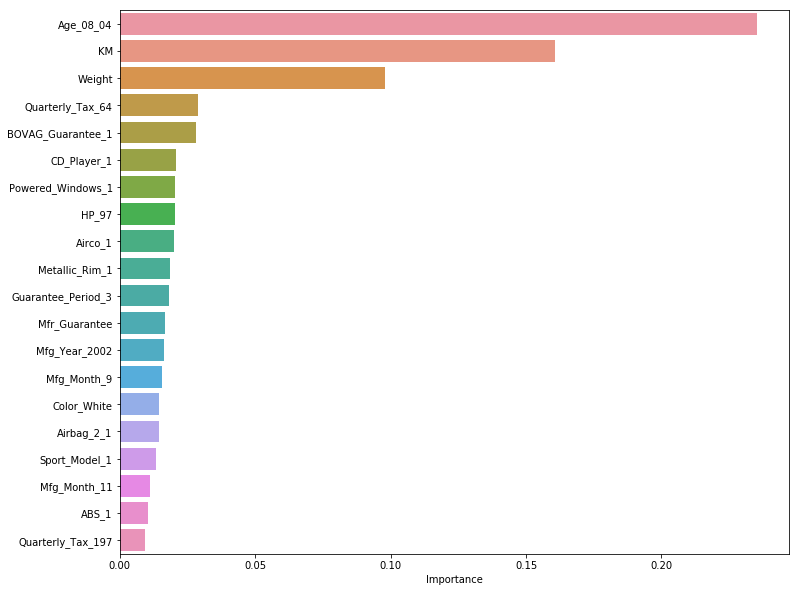

In [296]:
# gradientboosting을 활용한 feature importance
# params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#           'learning_rate': 0.01, 'loss': 'ls'}
GB = GradientBoostingRegressor()
GB.fit(X_scaled,y_train)
FI = pd.DataFrame({'Importance':GB.feature_importances_},index = X_train.columns)\
    .sort_values("Importance",ascending = False)
fig, axes = plt.subplots( figsize=(12,10))
g = sns.barplot(y=FI.index[:20],x = FI.Importance[:20] , orient='h')


### 9. PCA
    - PCA 를 하는 이유는 다중공선성이 분명 많을 것이기 때문에
    - 선형 결합으로 다시 표현하여 다중 공선성을 제거하기 위함.
    

In [303]:
pca = PCA(n_components = 101)  # 성분을 줄일수도 있는데 여기에서는 다중 공선성 제거 용도로만
train_X_pca = pca.fit_transform(X_scaled)
test_X_pca = pca.transform(test_X_scaled)

### 10. Modeling
    - GridSearch를 활용하자

In [308]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

### 단순 성적 확인

In [307]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter = 10000), RandomForestRegressor(),
         GradientBoostingRegressor(),SVR(),LinearSVR(), 
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000),BayesianRidge(),
          KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),ExtraTreesRegressor()
         ]

names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra"]

In [310]:
# Scaling 했을 때 결과
for name, model in zip(names, models):
    score = rmse_cv(model,X_scaled,y_train)#train_X_pca,y_train)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.115416, 0.0081
Ridge: 0.114040, 0.0073
Lasso: 0.133437, 0.0073
RF: 0.113135, 0.0053
GBR: 0.107781, 0.0068
SVR: 0.115851, 0.0028
LinSVR: 0.138003, 0.0279
Ela: 0.112701, 0.0077
SGD: 0.159468, 0.0247
Bay: 0.113622, 0.0072
Ker: 0.110340, 0.0048
Extra: 0.120481, 0.0077


In [328]:
# Scaling + PCA를 했을때 결과
for name, model in zip(names, models):
    score = rmse_cv(model,train_X_pca,y_train)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 134773936792.273148, 103096597606.0634
Ridge: 0.114040, 0.0073
Lasso: 0.144016, 0.0055
RF: 0.130909, 0.0056
GBR: 0.126260, 0.0024
SVR: 0.115851, 0.0028
LinSVR: 0.116219, 0.0081
Ela: 0.113490, 0.0071
SGD: 0.114044, 0.0072
Bay: 0.113622, 0.0072
Ker: 0.110200, 0.0046
Extra: 0.129342, 0.0032


### grid search
    - Model을 평가하는 방법
    - Model fitting은 데이터 다 넣고 하는것

In [331]:
def grid_get(model,X,y,param_grid):
    grid_search = GridSearchCV(model,param_grid, cv = 5, scoring= "neg_mean_squared_error")
    grid_search.fit(X,y)
    print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
    grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
    
    print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [332]:
# Lasso 
grid_get(Lasso(),train_X_pca,y_train,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11368917569318333
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.113759        0.001626
1  {'alpha': 0.0005, 'max_iter': 10000}         0.113689        0.001606
2  {'alpha': 0.0007, 'max_iter': 10000}         0.114064        0.001616
3  {'alpha': 0.0009, 'max_iter': 10000}         0.114745        0.001662


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

In [333]:
# Ridge 
grid_get(Ridge(),train_X_pca,y_train,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 35} 0.11769679096673907
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.117697        0.001647
1  {'alpha': 40}         0.118445        0.001645
2  {'alpha': 45}         0.119180        0.001643
3  {'alpha': 50}         0.119899        0.001642
4  {'alpha': 55}         0.120602        0.001641
5  {'alpha': 60}         0.121288        0.001640
6  {'alpha': 65}         0.121958        0.001640
7  {'alpha': 70}         0.122612        0.001641
8  {'alpha': 80}         0.123874        0.001645
9  {'alpha': 90}         0.125080        0.001652


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

In [334]:
# SVR
grid_get(SVR(),train_X_pca,y_train,{'C':[11,13,15],'kernel':["rbf"],
                                    "gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'} 0.11252377371690114
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.114231   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.113357   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.114183   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.113347   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.113809   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.112883   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.113914   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.113024   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.113278   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.112524   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.113388   
11  {'C': 15, 'epsilon': 0.009

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

In [336]:
# kernel Ridge
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid_get(KernelRidge(),train_X_pca,y_train,param_grid)

{'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.11185529017696537
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.112438   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.112259   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.112451   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.111918   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.112743   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.111855   

   std_test_score  
0        0.000813  
1        0.001003  
2        0.000630  
3        0.000776  
4        0.000584  
5        0.000668  


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

In [337]:

grid_get(ElasticNet(),train_X_pca,y_train,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})


{'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11369111821878929
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.113920   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.113843   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.113713   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.113691   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.113816   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.116616   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.113909   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.114101   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.118459   

   std_test_score  
0        0.001639  
1        0.001635  
2        0.001617  
3        0.001610  
4        0.001613  
5        0.001690  
6        0.001615  
7        0.001619  
8        0.0016

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

### Ensemble Methods
    - Weight Average : 가장 결과가 좋았던 svr, ker만 가지고 만들자
    - Stacking

In [344]:
svr= SVR(C= 15, epsilon= 0.008, gamma= 0.0004, kernel= 'rbf')
ker = KernelRidge(alpha= 0.4, coef0= 1, degree= 3, kernel= 'polynomial')

In [345]:
# Averageweight
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [346]:
weight_avg = AverageWeight(mod = [svr,ker],weight = [0.5,0.5])
score = rmse_cv(weight_avg,train_X_pca,y_train)
print(score.mean())

0.1107716322554166


In [347]:
weight_avg.fit(train_X_pca,y_train)

AverageWeight(mod=[SVR(C=15, cache_size=200, coef0=0.0, degree=3, epsilon=0.008, gamma=0.0004,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), KernelRidge(alpha=0.4, coef0=1, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None)],
       weight=[0.5, 0.5])

### test error 확인
    - 한번도 안본 데이터로 확인해보니 꽤 좋은 성적이 나온다

In [354]:

from sklearn.metrics import mean_squared_error
print('test error', np.sqrt(mean_squared_error(weight_avg.predict(test_X_pca),y_test)))

test error 0.10352860520111272


### Stacking

In [356]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    # 첫 Layer에 있는 결과를 return 하는 것!
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [358]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [369]:

stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [379]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = Imputer().fit_transform(train_X_pca)
b = Imputer().fit_transform(y_train.reshape(-1,1)).ravel()

score = rmse_cv(stack_model,a,b)
print(score.mean())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


0.11340663334587023


## Stacking test error

In [385]:
a = Imputer().fit_transform(train_X_pca)
b = Imputer().fit_transform(y_train.reshape(-1,1)).ravel()

stack_model.fit(a,b)
# stack_model()
print('test error', np.sqrt(mean_squared_error(stack_model.predict(test_X_pca),y_test)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


test error 0.09912602332635767
